In [40]:
import json
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import csv
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import itertools
import networkx as nx
import math
from sklearn.decomposition import TruncatedSVD 
from sklearn.manifold import TSNE

In [2]:
with open('train.json', 'r') as infile: 
    recipes = json.load(infile)

### Some basic numbers

In [3]:
print "Number of recipes", len(recipes)

Number of recipes 39774


In [4]:
cuisine_country = {
    'italian' : ('Italy', 'Europe'), 
    'mexican' : ('Mexico', 'North America'), 
    'southern_us' : ('United States', 'North America'), 
    'indian' : ('India', 'Asia'),
    'chinese' : ('China', 'Asia'),
    'french' : ('France', 'Europe'), 
    'cajun_creole' : ('United States', 'North America'), 
    'thai' : ('Thailand', 'Asia'),
    'japanese' : ('Japan', 'Asia'),
    'greek' : ('Greece', 'Europe'), 
    'spanish' : ('Spain', 'Europe'), 
    'korean' : ('South Korea', 'Asia'),
    'vietnamese' : ('Vietnam', 'Asia'),
    'moroccan': ('Morocco', 'Africa'),
    'british': ('United Kingdom', 'Europe'), 
    'filipino': ('Philippines', 'Asia'),
    'irish': ('Ireland', 'Europe'), 
    'jamaican': ('Jamaica', 'North America'), 
    'russian': ('Russia', 'Europe'), 
    'brazilian': ('Brazil', 'South America'), 
}

### What cuisines are there?
How many times does each cuisine appear in our dataset? 

In [5]:
cuisines = []
for d in recipes: 
    cuisines.append(d['cuisine'])

In [6]:
cuisine_counts = Counter(cuisines)
print("Number of cuisines:", len(cuisine_counts))
x = []
y = []
for tup in cuisine_counts.most_common(): 
    print(tup[0], tup[1])
    x.append(tup[0])
    y.append(tup[1])

('Number of cuisines:', 20)
(u'italian', 7838)
(u'mexican', 6438)
(u'southern_us', 4320)
(u'indian', 3003)
(u'chinese', 2673)
(u'french', 2646)
(u'cajun_creole', 1546)
(u'thai', 1539)
(u'japanese', 1423)
(u'greek', 1175)
(u'spanish', 989)
(u'korean', 830)
(u'vietnamese', 825)
(u'moroccan', 821)
(u'british', 804)
(u'filipino', 755)
(u'irish', 667)
(u'jamaican', 526)
(u'russian', 489)
(u'brazilian', 467)


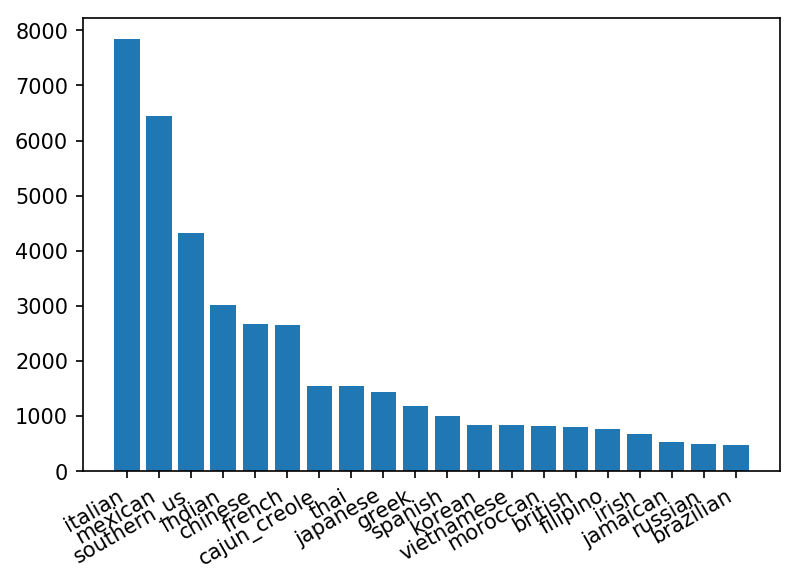

In [7]:
plt.figure(dpi=150)
plt.bar(x, y)
plt.xticks(rotation=30, ha='right')
plt.show()

### What ingredients are popular per cuisine? 

In [8]:
cuisine_ing = defaultdict(Counter)
for d in recipes: 
    cuisine = d['cuisine']
    ing = [i.lower() for i in d['ingredients']]
    cuisine_ing[cuisine].update(ing)

In [9]:
for cuisine in cuisine_ing: 
    print(cuisine)
    print(cuisine_ing[cuisine].most_common(10))
    print('-------------')

irish
[(u'salt', 376), (u'butter', 219), (u'all-purpose flour', 219), (u'onions', 132), (u'potatoes', 120), (u'sugar', 120), (u'baking soda', 115), (u'baking powder', 112), (u'milk', 111), (u'carrots', 105)]
-------------
mexican
[(u'salt', 2720), (u'onions', 1493), (u'ground cumin', 1346), (u'garlic', 1317), (u'olive oil', 1289), (u'chili powder', 1236), (u'jalapeno chilies', 1146), (u'sour cream', 1076), (u'avocado', 1044), (u'corn tortillas', 946)]
-------------
chinese
[(u'soy sauce', 1363), (u'sesame oil', 915), (u'salt', 907), (u'corn starch', 906), (u'sugar', 824), (u'garlic', 763), (u'water', 762), (u'green onions', 628), (u'vegetable oil', 602), (u'scallions', 591)]
-------------
filipino
[(u'salt', 421), (u'garlic', 325), (u'water', 310), (u'onions', 310), (u'soy sauce', 251), (u'pepper', 199), (u'oil', 166), (u'sugar', 136), (u'carrots', 128), (u'ground black pepper', 124)]
-------------
vietnamese
[(u'fish sauce', 392), (u'sugar', 344), (u'salt', 264), (u'garlic', 239), (u'

In [10]:
with open('top10_ing.csv', 'w') as outfile: 
    fieldnames = ['Cuisine', 'Continent', 'Ingredient', 'Count']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    for cuisine in cuisine_ing: 
        continent = cuisine_country[cuisine][1]
        for tup in cuisine_ing[cuisine].most_common(10): 
            d = {}
            d['Cuisine'] = cuisine
            d['Continent'] = continent
            d['Ingredient'] = tup[0]
            d['Count'] = tup[1]
            writer.writerow(d)

Reformat into csv, where columns are Cuisine, Ingredient, Ingredient Count, Country, Continent

In [11]:
with open('food_dataset.csv', 'w') as csvfile: 
    fieldnames = ['cuisine', 'ingredient', 'count', 'country', 'continent']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for cuisine in cuisine_ing: 
        for ing in cuisine_ing[cuisine]: 
            d = {}
            d['cuisine'] = cuisine
            d['ingredient'] = ing.encode('utf-8')
            d['count'] = cuisine_ing[cuisine][ing]
            d['country'], d['continent'] = cuisine_country[cuisine]
            writer.writerow(d)

### What cuisines are similar to each other? 

In [12]:
ingredients = set()
for cuisine in cuisine_ing: 
    ingredients.update(list(cuisine_ing[cuisine].keys()))
ingredients = sorted(ingredients)
print("Total number of unique ingredients:", len(ingredients))

('Total number of unique ingredients:', 6703)


In [13]:
continent_cuisine = defaultdict(list)
for cuisine in cuisine_country: 
    tup = cuisine_country[cuisine]
    continent = tup[1]
    continent_cuisine[continent].append(cuisine)
cuisines = []
for continent in continent_cuisine: 
    cuisines.extend(continent_cuisine[continent])
matrix = np.zeros((len(cuisines), len(ingredients)))
for i, c in enumerate(cuisines): 
    ings = cuisine_ing[c]
    for ing in ings: 
        j = ingredients.index(ing)
        matrix[i][j] = ings[ing]
model = TfidfTransformer()
matrix = model.fit_transform(matrix)
sim = cosine_similarity(matrix)

In [14]:
matrix_np = matrix.toarray()
with open('tfidf_weights.csv', 'w') as outfile: 
    outfile.write('cuisine,ingredient,tf-idf\n')
    for i in range(len(cuisines)): 
        cuisine = cuisines[i]
        top10 = matrix_np[i].argsort()[-20:][::-1]
        for j in top10: 
            ingredient = ingredients[j]
            tfidf = matrix_np[i][j]
            outfile.write(cuisine + ',' + ingredient.encode('utf-8') + ',' + str(tfidf) + '\n')

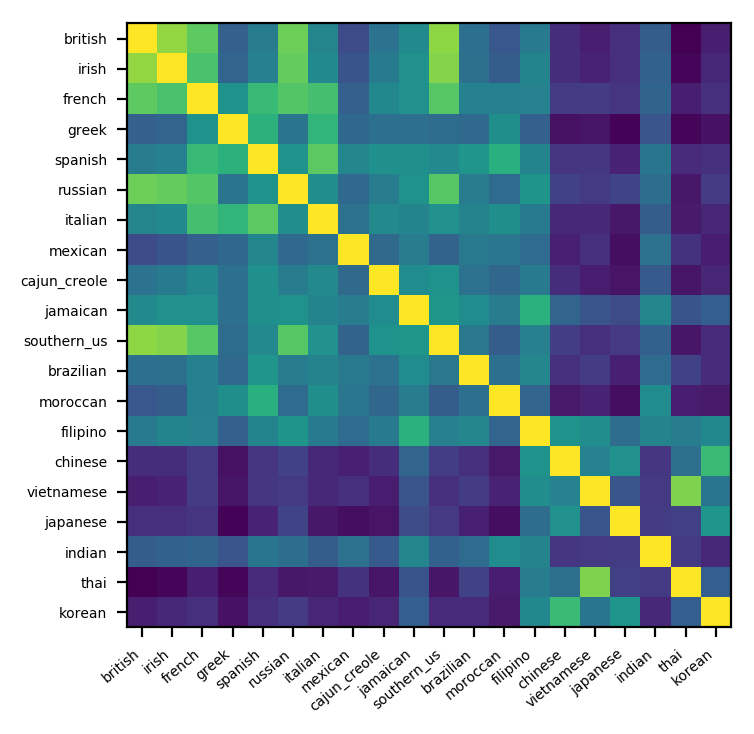

In [15]:
plt.subplots(dpi=200)
plt.imshow(sim)
plt.xticks(np.arange(len(cuisines)), cuisines, rotation=40, ha='right', fontsize=5)
plt.yticks(np.arange(len(cuisines)), cuisines, fontsize=5)
plt.show()

In [16]:
with open('similarity.csv', 'w') as outfile: 
    outfile.write('cuisine 1,continent 1,cuisine 2,continent 2,similarity\n')
    for i, c1 in enumerate(cuisines): 
        for j, c2 in enumerate(cuisines): 
            outfile.write(c1 + ',' + cuisine_country[c1][1] + ','+ c2 + ',' + \
                          cuisine_country[c2][1] + ',' + str(sim[i][j]) + '\n')

In [45]:
dim_reduct = TruncatedSVD(n_components=2)
dr_matrix = dim_reduct.fit_transform(matrix.toarray())
with open('dim_reduct_vectors.csv', 'w') as outfile: 
    fieldnames = ['Cuisine', 'Continent', 'Country', 'Dim 1', 'Dim 2', 
                  'Cuisine-Specific Ingredients', 'Nearest Neighbor']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    for i, c in enumerate(cuisines): 
        d = {}
        d['Cuisine'] = c.replace('_', ' ').title()
        d['Continent'] = cuisine_country[c][1]
        d['Country'] = cuisine_country[c][0]
        d['Dim 1'] = dr_matrix[i][0]
        d['Dim 2'] = dr_matrix[i][1]
        d['Cuisine-Specific Ingredients'] = 'TODO, TODO, TODO, TODO, TODO'
        d['Nearest Neighbor'] = 'TODO'
        writer.writerow(d)

### What kinds of ingredients do we have? 

In [17]:
last_token_counts = Counter()
for ing in ingredients: 
    tokens = ing.split(' ')
    if len(tokens) > 1: 
        last_token_counts[tokens[-1]] += 1
for tup in last_token_counts.most_common(15): 
    print tup[0], tup[1]

sauce 187
cheese 162
mix 119
powder 83
beans 79
juice 70
paste 70
flour 69
oil 69
seasoning 66
leaves 66
broth 64
rice 55
cream 55
fillets 54


### Cuisine co-occurrence

What are common pairings of ingredients in recipes? 

In [18]:
co_counts = Counter()
ing_counts = Counter()
for d in recipes: 
    cuisine = d['cuisine']
    ing = [i.lower() for i in d['ingredients']]
    ing_counts.update(ing)
    for tup in itertools.combinations(ing, 2): 
        co_counts[tuple(sorted(tup))] += 1
print(co_counts.most_common(10))

[((u'onions', u'salt'), 4392), ((u'olive oil', u'salt'), 4180), ((u'salt', u'water'), 3960), ((u'pepper', u'salt'), 3844), ((u'garlic', u'salt'), 3749), ((u'all-purpose flour', u'salt'), 3079), ((u'salt', u'sugar'), 3061), ((u'garlic cloves', u'salt'), 2998), ((u'butter', u'salt'), 2777), ((u'ground black pepper', u'salt'), 2737)]


In [19]:
npmi = Counter()
total_pairs = sum(co_counts.values())
total_ing = sum(ing_counts.values())
for pair in co_counts: 
    p_xy = co_counts[pair] / float(total_pairs)
    p_x = ing_counts[pair[0]] / float(total_ing)
    p_y = ing_counts[pair[1]] / float(total_ing)
    npmi[pair] = math.log(p_xy / (p_x*p_y)) / -math.log(p_xy)
print(npmi.most_common(20))

[((u'capocollo', u'spicy salami'), 0.7700711591801532), ((u'spice islands garlic salt', u'spice islands ground cumin seed'), 0.761357256631465), ((u'hawaiian salt', u'sliced mango'), 0.761357256631465), ((u'bacardi\xae mixers margarita mix', u'bacardi\xae superior'), 0.761357256631465), ((u'icing mix', u'poured fondant'), 0.761357256631465), ((u'argo corn starch', u'karo'), 0.761357256631465), ((u'royal olives', u'san marzano diced tomatoes'), 0.761357256631465), ((u'gelatin sheet', u'sparkling ros\xe9 wine'), 0.761357256631465), ((u'annatto oil', u'lemon soda'), 0.761357256631465), ((u'pippin apples', u'rum raisin ice cream'), 0.761357256631465), ((u'aloe juice', u'tonic water'), 0.761357256631465), ((u'chocolate graham cracker crumbs', u'heath candy bars'), 0.761357256631465), ((u'french style sandwich rolls', u'liverwurst'), 0.761357256631465), ((u'buckwheat honey', u'psyllium husks'), 0.761357256631465), ((u'garbonzo bean', u'whole garam masala'), 0.761357256631465), ((u'hawaiian s

Write out the edges and nodes to a file...

We filter to only pairs that have a frequency of at least past some threshold.  

In [20]:
nodes = set()
num_edges = 0
with open('food_network.csv', 'w') as outfile: 
    fieldnames = ['Source', 'Target', 'Weight']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    for pair in co_counts: 
        if co_counts[pair] < 50: continue
        d = {}
        d['Source'] = pair[0].encode('utf-8')
        d['Target'] = pair[1].encode('utf-8')
        d['Weight'] = co_counts[pair] 
        writer.writerow(d)
        num_edges += 1
        nodes.add(pair[0])
        nodes.add(pair[1])
print("Number of nodes:", len(nodes))
print("Number of edges:", num_edges)

('Number of nodes:', 652)
('Number of edges:', 6946)


In [21]:
nodes = set()
num_edges = 0
with open('food_network_npmi.csv', 'w') as outfile: 
    fieldnames = ['source', 'target', 'value']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    for pair in npmi: 
        if npmi[pair] < 0.25: continue
        if ing_counts[pair[0]] < 50: continue
        if ing_counts[pair[1]] < 50: continue    
        d = {}
        d['source'] = pair[0].encode('utf-8')
        d['target'] = pair[1].encode('utf-8')
        d['value'] = npmi[pair]
        writer.writerow(d)
        num_edges += 1
        nodes.add(pair[0])
        nodes.add(pair[1])
print("Number of nodes:", len(nodes))
print("Number of edges:", num_edges)

('Number of nodes:', 922)
('Number of edges:', 3744)


In [22]:
with open('food_network_npmi_nodes.csv', 'w') as outfile: 
    fieldnames = ['id', 'label','frequency', 'group']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    for n in nodes: 
        d = {}
        d['id'] = n.encode('utf-8')
        d['label'] = n.encode('utf-8')
        d['frequency'] = ing_counts[n]
        d['group'] = 1
        writer.writerow(d)

In [23]:
for pair in co_counts: 
    if pair == ('condensed cream of chicken soup', 'condensed cream of mushroom soup'): print(pair, co_counts[pair])

((u'condensed cream of chicken soup', u'condensed cream of mushroom soup'), 16)


Format into json for D3 input.

In [24]:
j = {}
j['nodes'] = []
for n in nodes: 
    d = {}
    d['id'] = n.encode('utf-8')
    d['group'] = 1 # TODO: get most affiliated cuisine's continent
    j['nodes'].append(d)
j['links'] = []
for pair in npmi: 
    d = {}
    d['source'] = pair[0].encode('utf-8')
    d['target'] = pair[1].encode('utf-8')
    d['value'] = npmi[pair]
    j['links'].append(d)
with open('food_network.json', 'w') as outfile:
    json.dump(j, outfile)